# 1. Import libraries - set path's - define functions

In [414]:
### Import all necessary libraries

import pandas as pd
import numpy as np
import psycopg2 # needed to get database exception errors when uploading dataframe
import requests # package for getting data from the web
import matplotlib.pyplot as plt 
import seaborn as sns 
from zipfile import * # package for unzipping zip files
from sql_functions import get_engine # Import the get_engine function from our sql_functions.
from dotenv import load_dotenv
load_dotenv()
import time 

In [3]:
### Specify data path 

path ='data/' 
# Create the data folder
!mkdir {path}

mkdir: data/: File exists


In [4]:
### function to get specified csv file from the website https://transtats.bts.gov

def download_data(year, month):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
    # Download the database
    r = requests.get(f'{url}', verify=False)
    # Save database to local file storage
    with open(path+zip_file, 'wb') as f:
        f.write(r.content)
        print(f'--> zip_file with name: {zip_file} downloaded succesfully.' )

In [5]:
### function to extract the csv files inside the zip files

def extract_zip(year, month):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    with ZipFile(path+zip_file, 'r') as zip_ref:
        zip_ref.extractall(path)
        csv_file =  zip_ref.namelist()[0]
        print(f'--> zip_file was succesfully extracted to: {csv_file}.' )

# 1.1. Import Weather Database from Meteostat

In [663]:
import os 
# set url base
url_base = 'https://meteostat.p.rapidapi.com'
frequency = 'daily'

# set url as daily
url = "https://meteostat.p.rapidapi.com/stations/daily"

locations =['74486',
            '72503',
            '72509',
            '72408',
            '72403']

# set headers
headers = {
 "X-RapidAPI-Key": os.getenv('meteostat_api_key'),
 "X-RapidAPI-Host": "meteostat.p.rapidapi.com"
}

# Create empty dataframe, will be used to append each location's weather data
weather_df = pd.DataFrame([])

# set parameters
for location in locations:
  time.sleep(1)
  querystring = {"station":location,"start":"2010-12-01","end":"2011-01-31"}

 # Request data from url
  response = requests.request("GET", url, headers=headers, params=querystring)
  # Decode repsonse with json decoder 
  weather_temp = response.json()
  # Flatten json response
  weather_temp_df = pd.json_normalize(weather_temp, 
                                      sep="_", 
                                      record_path="data", 
                                      meta=[["meta", "generated"]], 
                                      record_prefix="weather_",
                                      errors='ignore')

  weather_temp_df['weather_id'] = location
 # concatenate dataframes
  weather_df = pd.concat([weather_df, weather_temp_df], ignore_index=True)
 

# Print final dataset weather_df
weather_df.head(2)

,weather_date,weather_tavg,weather_tmin,weather_tmax,weather_prcp,weather_snow,weather_wdir,weather_wspd,weather_wpgt,weather_pres,weather_tsun,meta_generated,weather_id
0,2010-12-01,11.7,4.4,15.0,24.6,0.0,173.0,37.4,None,1010.5,None,2023-03-29 12:53:44,74486
1,2010-12-02,3.6,1.1,6.7,0.0,0.0,309.0,21.6,None,1017.9,None,2023-03-29 12:53:44,74486


In [266]:
acft_dict= {
            '74486': 'John F Kennedy International Airport',
            '72503': 'La Guardia Airport',
            '72509': 'General Edward Lawrence Logan International Airport',
            '72408': 'Philadelphia International Airport',
            '72403': 'Washington Dulles International Airport'}

# Assign values in the aircraft_type column by mapping the keys from type_acft column to the values in the acft_dict dictionary.
#weather_df['weather_id'] = weather_df['weather_id'].map(acft_dict)
#weather_df.rename(columns={'weather_id' : 'airport_name'}, inplace=True)
weather_df.head(2)

,weather_date,weather_tavg,weather_tmin,weather_tmax,weather_prcp,weather_snow,weather_wdir,weather_wspd,weather_wpgt,weather_pres,weather_tsun,meta_generated,airport_name
0,2010-12-01,11.7,4.4,15.0,24.6,0.0,173.0,37.4,None,1010.5,None,2023-03-29 12:53:44,John F Kennedy International Airport
1,2010-12-02,3.6,1.1,6.7,0.0,0.0,309.0,21.6,None,1017.9,None,2023-03-29 12:53:44,John F Kennedy International Airport


In [263]:
weather_df_f = weather_df[['weather_date', 'weather_tavg', 'weather_tmin', 'weather_tmax',
       'weather_prcp', 'weather_snow', 'weather_wspd', 'airport_name']]

In [267]:
weather_df_f['weather_date'] = pd.to_datetime(weather_df_f['weather_date'])
weather_df_f.head(2)

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_28863/1736892624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df_f['weather_date'] = pd.to_datetime(weather_df_f['weather_date'])


,weather_date,weather_tavg,weather_tmin,weather_tmax,weather_prcp,weather_snow,weather_wspd,airport_name
0,2010-12-01,11.7,4.4,15.0,24.6,0.0,37.4,John F Kennedy International Airport
1,2010-12-02,3.6,1.1,6.7,0.0,0.0,21.6,John F Kennedy International Airport


# 2. Download Data from transtats.bts.gov

* only do once!

In [ ]:
### Download Data for 12/2010

years_list = [2010] # list of years you want to look at (can of course also be a single year)
months_list = [12] # list of months you want to look at (can of course also be a single month)

# download flights data as zipfile(s)
# we use a nested loop to specify the years and months to define the range of the data we would like to have 
for year in years_list:
    for month in months_list:
        download_data(year, month)
        extract_zip(year, month)

In [ ]:
### Download Data for 01/2011

years_list = [2011] # list of years you want to look at (can of course also be a single year)
months_list = [1] # list of months you want to look at (can of course also be a single month)

# download flights data as zipfile(s)
# we use a nested loop to specify the years and months to define the range of the data we would like to have 
for year in years_list:
    for month in months_list:
        download_data(year, month)
        extract_zip(year, month)

# 3. Read in Downloaded Files

In [6]:
### read in 12/2010 and define as df_1210

csv_file = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2010_12.csv'

# Read in your data
df_1210 = pd.read_csv(path+csv_file, low_memory = False)
display(df_1210.shape)
display(df_1210.head())

(539382, 110)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2010,4,12,28,2,2010-12-28,WN,19393,WN,N453WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,4,12,28,2,2010-12-28,WN,19393,WN,N460WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,4,12,28,2,2010-12-28,WN,19393,WN,N469WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,4,12,28,2,2010-12-28,WN,19393,WN,N611SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,4,12,28,2,2010-12-28,WN,19393,WN,N664WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
### read in 01/2011 and define as df_0111

csv_file2 = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_1.csv'

# Read in your data
df_0111 = pd.read_csv(path+csv_file2, low_memory = False)
display(df_0111.shape)
display(df_0111.head())

(494400, 110)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2011,1,1,1,6,2011-01-01,AA,19805,AA,N329AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,1,1,2,7,2011-01-02,AA,19805,AA,N339AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,1,1,3,1,2011-01-03,AA,19805,AA,N332AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,1,1,4,2,2011-01-04,AA,19805,AA,N335AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011,1,1,5,3,2011-01-05,AA,19805,AA,N335AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
### combine two df's to `df`

df = pd.concat([df_1210, df_0111])

# 4. Prepare the df for further processing

In [9]:
### Define Columns that should be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'ActualElapsedTime',
                'Distance',
                'Cancelled',
                'Diverted'
                ]

In [10]:
### rename the columns as in the source csv files 

schema = 'hh_analytics_23_1' # based on schema used in class 
engine = get_engine() # assign engine to be able to query against the database

table_name_sql = f'''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='{schema}'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

/var/folders/7p/5hb3bs814mz8v_v78023f0sh0000gn/T/ipykernel_28863/3450815345.py:11: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  c_names = engine.execute(table_name_sql).fetchall()


[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('actual_elapsed_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [11]:
### clean up the results into a clean list `new_column_names`

new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names    

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'actual_elapsed_time',
 'distance',
 'cancelled',
 'diverted']

In [12]:
### function, to make our csv file ready to be uploaded to SQL.  
### We only keep to above specified columns and convert the datatypes.

def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    df_airline['ActualElapsedTime']= pd.to_numeric(df_airline['ActualElapsedTime'], downcast='integer', errors='coerce')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [13]:
### Call function and check resulting dataframe

df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2010-12-28,1453.0,1430,23.0,1727.0,1715,12.0,WN,N453WN,233,PBI,PHL,142.0,154.0,951.0,0,0
1,2010-12-28,958.0,950,8.0,1245.0,1235,10.0,WN,N460WN,971,PBI,PHL,141.0,167.0,951.0,0,0
2,2010-12-28,1750.0,1700,50.0,1840.0,1750,50.0,WN,N469WN,547,PBI,TPA,35.0,50.0,174.0,0,0
3,2010-12-28,1207.0,1135,32.0,1301.0,1225,36.0,WN,N611SW,825,PBI,TPA,41.0,54.0,174.0,0,0
4,2010-12-28,601.0,600,1.0,650.0,650,0.0,WN,N664WN,3517,PBI,TPA,34.0,49.0,174.0,0,0


In [14]:
### specifying the airports we are interested in and put them as a list in the function.

def select_airport(df, airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [15]:
### Execute function, filtering for desired airports

airports=['JFK', 'LGA', 'EWR', 'BOS', 'PHL', 'IAD', 'YYZ']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2010-12-28,1453.0,1430,23.0,1727.0,1715,12.0,WN,N453WN,233,PBI,PHL,142.0,154.0,951.0,0,0
1,2010-12-28,958.0,950,8.0,1245.0,1235,10.0,WN,N460WN,971,PBI,PHL,141.0,167.0,951.0,0,0
44,2010-12-28,1700.0,1555,65.0,1805.0,1720,45.0,WN,N223WN,560,PHL,BNA,106.0,125.0,675.0,0,0
45,2010-12-28,907.0,815,52.0,1050.0,940,70.0,WN,N445WN,3323,PHL,BNA,100.0,163.0,675.0,0,0
46,2010-12-28,1902.0,1745,77.0,2014.0,1905,69.0,WN,N453WN,233,PHL,BOS,49.0,72.0,280.0,0,0


# 5. Pushing the prepared data to a table in the database
* only do once!

In [16]:
### Specifying which table within our database we want to push our data to

table_name = 'flights_r1_ja'

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The flights_r1_ja table was imported successfully.


In [17]:
### Just to be sure: Check if the number of rows match

table_name_sql = f'''SELECT count(*) 
                    FROM {schema}.{table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

True

# 6. In SQL: join the Airport-Information for Origin & Destination

```SQL
-- Join Airport-information for Origin and Destination in SQL:
SELECT frj.flight_date,
       MAKE_TIME((frj.dep_time::INT / 100), (frj.dep_time::INT % 100), 0) AS dep_time, 
       MAKE_TIME((frj.sched_dep_time::INT / 100), (frj.sched_dep_time::INT % 100), 0) AS sched_dep_time, 
       frj.dep_delay,
       MAKE_TIME((frj.arr_time::INT / 100), (frj.arr_time::INT % 100), 0) AS arr_time, 
       MAKE_TIME((frj.sched_arr_time::INT / 100), (frj.sched_arr_time::INT % 100), 0) AS sched_arr_time, 
       frj.arr_delay,
       frj.airline,
       frj.tail_number,
       frj.flight_number,
       frj.origin,
       frj.dest,
       frj.air_time,
       frj.actual_elapsed_time,
       frj.distance,
       frj.cancelled,
       frj.diverted,
       a1.name AS origin_name,
       a1.lat AS origin_lat,
       a1.lon AS origin_lon,
       a1.city AS origin_city,
       a1.country AS origin_country,
       a2.name AS dest_name,
       a2.lat AS dest_lat,
       a2.lon AS dest_lon,
       a2.city AS dest_city,
       a2.country AS dest_country
FROM flights_r1_ja frj 
LEFT JOIN airports a1 ON frj.origin = a1.faa
LEFT JOIN airports a2 ON frj.dest = a2.faa;
````

--> safed as `flights_airports_r1.csv` in Data Folder

# 7. Data Cleaning 

In [138]:
### read in ready csv as `flights_airports`

flights_airports = pd.read_csv(f'data/flights_airports_r1.csv')

In [139]:
### function for specifiyng only origin airports 

def select_airport_origin(df, flights_airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df_out = df.loc[(df.origin.isin(flights_airports))]
    return df_out

In [140]:
### as we decided in the team, to only concentrate on the origin destinations of the specified
### faa's (JFK, LGA, BOS, PHL, IAD, YYZ) we filter the DF to these values in `origin` 

### Execute `select_airport_origin` function from above, filtering for desired values

keep_faa = ["JFK", "LGA", "BOS", "PHL", "IAD", "YYZ"]
if len(keep_faa) > 0:
    flights_airports_new = select_airport_origin(flights_airports, keep_faa)
else:
    flights_airports_new = flights_airports
    
flights_airports_new.origin.unique()


array(['PHL', 'BOS', 'IAD', 'LGA', 'JFK'], dtype=object)

In [141]:
### drop not needed columns 

keeper = ["flight_date", "dep_time", "dep_delay", "origin_city", "origin_name", "dest_city", "dest_name", "dest_country", "airline", "cancelled", "diverted"]

flights_airports_new = flights_airports_new[keeper]
flights_airports_new.head()

,flight_date,dep_time,dep_delay,origin_city,origin_name,dest_city,dest_name,dest_country,airline,cancelled,diverted
2,2010-12-28 00:00:00.000,17:00:00,65.0,Philadelphia,Philadelphia International Airport,Nashville,Nashville International Airport,United States,WN,0,0
3,2010-12-28 00:00:00.000,09:07:00,52.0,Philadelphia,Philadelphia International Airport,Nashville,Nashville International Airport,United States,WN,0,0
4,2010-12-28 00:00:00.000,19:02:00,77.0,Philadelphia,Philadelphia International Airport,Boston,General Edward Lawrence Logan International Ai...,United States,WN,0,0
5,2010-12-28 00:00:00.000,21:46:00,61.0,Philadelphia,Philadelphia International Airport,Boston,General Edward Lawrence Logan International Ai...,United States,WN,0,0
6,2010-12-28 00:00:00.000,15:50:00,30.0,Philadelphia,Philadelphia International Airport,Boston,General Edward Lawrence Logan International Ai...,United States,WN,0,0


In [143]:
### convert flight_date, dep_time, dep_delay to (date)time format 

import datetime 
flights_airports_new['dep_time'] = pd.to_datetime(flights_airports_new['dep_time']).dt.time
flights_airports_new['flight_date'] = pd.to_datetime(flights_airports_new['flight_date'])


In [136]:
flights_airports_new.head()

,flight_date,dep_time,dep_delay,origin_city,origin_name,dest_city,dest_name,dest_country,airline,cancelled,diverted
2,2010-12-28,17:00:00,65.0,Philadelphia,Philadelphia International Airport,Nashville,Nashville International Airport,United States,WN,0,0
3,2010-12-28,09:07:00,52.0,Philadelphia,Philadelphia International Airport,Nashville,Nashville International Airport,United States,WN,0,0
4,2010-12-28,19:02:00,77.0,Philadelphia,Philadelphia International Airport,Boston,General Edward Lawrence Logan International Ai...,United States,WN,0,0
5,2010-12-28,21:46:00,61.0,Philadelphia,Philadelphia International Airport,Boston,General Edward Lawrence Logan International Ai...,United States,WN,0,0
6,2010-12-28,15:50:00,30.0,Philadelphia,Philadelphia International Airport,Boston,General Edward Lawrence Logan International Ai...,United States,WN,0,0


In [145]:
flights_airports_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79602 entries, 2 to 184835
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   flight_date   79602 non-null  datetime64[ns]
 1   dep_time      73344 non-null  object        
 2   dep_delay     73344 non-null  float64       
 3   origin_city   79602 non-null  object        
 4   origin_name   79602 non-null  object        
 5   dest_city     79602 non-null  object        
 6   dest_name     79602 non-null  object        
 7   dest_country  79602 non-null  object        
 8   airline       79602 non-null  object        
 9   cancelled     79602 non-null  int64         
 10  diverted      79602 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 7.3+ MB


In [151]:
### check for null values 

flights_airports_new.isnull().sum()

flight_date        0
dep_time        6258
dep_delay       6258
origin_city        0
origin_name        0
dest_city          0
dest_name          0
dest_country       0
airline            0
cancelled          0
diverted           0
dtype: int64

In [171]:
### check for null values 
flights_airports_new[flights_airports_new['dep_time'].isnull()]

### confirm that all null values are flights that have been cancelled 
flights_airports_new[flights_airports_new['dep_time'].isnull()]['cancelled'].unique()


array([1])

# 8. Merge Flights & Weather

In [294]:
### combine the two dataframes on Name of Airport and Date 

combined = (pd.merge(flights_airports_new, weather_df_f
                     [["airport_name", "weather_date", "weather_tavg", "weather_tmin", "weather_tmax", "weather_prcp", "weather_snow",  "weather_wspd" ]]
                     , left_on=["origin_name", "flight_date"]
                     , right_on=["airport_name", "weather_date"]
                     , how="left"))

In [349]:
### drop unnecessary columns 

combined.drop(["airport_name", "weather_date"], axis=1, inplace=True)
combined.head(2)

,flight_date,dep_time,dep_delay,origin_city,origin_name,dest_city,dest_name,dest_country,airline,cancelled,diverted,weather_tavg,weather_tmin,weather_tmax,weather_prcp,weather_snow,weather_wspd
0,2010-12-28,17:00:00,65.0,Philadelphia,Philadelphia International Airport,Nashville,Nashville International Airport,United States,WN,0,0,0.1,-3.3,3.9,0.0,178.0,24.5
1,2010-12-28,09:07:00,52.0,Philadelphia,Philadelphia International Airport,Nashville,Nashville International Airport,United States,WN,0,0,0.1,-3.3,3.9,0.0,178.0,24.5


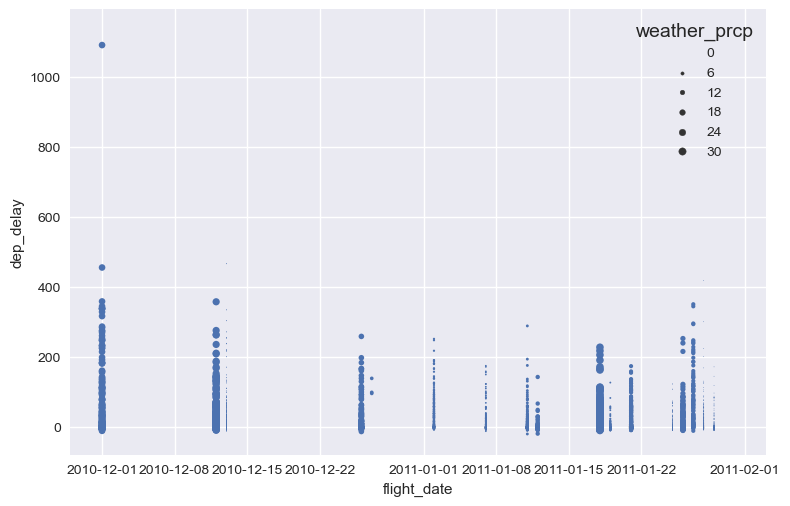

In [559]:
### bubble scatterplot 

foo = combined.loc[combined['origin_name'] == 'John F Kennedy International Airport']
sns.scatterplot(data=foo, x='flight_date', y="dep_delay", size="weather_prcp", sizes=(0,30))
plt.show()

# 9. Group by Flight Date & Calculate Statistics

In [326]:
### drop unnecessary columns 

delayed = combined.drop(['dep_time', 'origin_city', 'dest_city', 'dest_name', 'dest_country', 'airline'], axis=1)
delayed.head()

,flight_date,dep_delay,origin_name,cancelled,diverted,weather_tavg,weather_tmin,weather_tmax,weather_prcp,weather_snow,weather_wspd
0,2010-12-28,65.0,Philadelphia International Airport,0,0,0.1,-3.3,3.9,0.0,178.0,24.5
1,2010-12-28,52.0,Philadelphia International Airport,0,0,0.1,-3.3,3.9,0.0,178.0,24.5
2,2010-12-28,77.0,Philadelphia International Airport,0,0,0.1,-3.3,3.9,0.0,178.0,24.5
3,2010-12-28,61.0,Philadelphia International Airport,0,0,0.1,-3.3,3.9,0.0,178.0,24.5
4,2010-12-28,30.0,Philadelphia International Airport,0,0,0.1,-3.3,3.9,0.0,178.0,24.5


In [359]:
### aggregrate to the desired statistical values 

delayed = delayed.groupby(['flight_date', 'origin_name']).agg(
                    average_delay=('dep_delay', 'mean'),
                    maximium_delay=('dep_delay', 'max'),
                    number_of_flights=('flight_date', 'count'),
                    perc_cancelled=('cancelled', 'mean'),
                    perc_diverted=('diverted', 'mean'),
                    weather_tavg=('weather_tavg', 'mean'),
                    weather_tmin=('weather_tmin', 'mean'),
                    weather_tmax=('weather_tmax', 'mean'),
                    weather_prcp=('weather_prcp', 'mean'),
                    weather_snow=('weather_snow', 'mean'),
                    weather_wspd=('weather_wspd', 'mean')
                    ).reset_index()

In [368]:
delayed.head(2)

,flight_date,origin_name,average_delay,maximium_delay,number_of_flights,perc_cancelled,perc_diverted,weather_tavg,weather_tmin,weather_tmax,weather_prcp,weather_snow,weather_wspd
0,2010-12-01,General Edward Lawrence Logan International Ai...,22.633333,362.0,333,0.111111,0.003003,9.8,7.8,13.3,9.7,NaN,24.8
1,2010-12-01,John F Kennedy International Airport,66.383929,1091.0,292,0.236301,0.000000,11.7,4.4,15.0,24.6,0.0,37.4


# 10. First EDA

<AxesSubplot: xlabel='flight_date'>

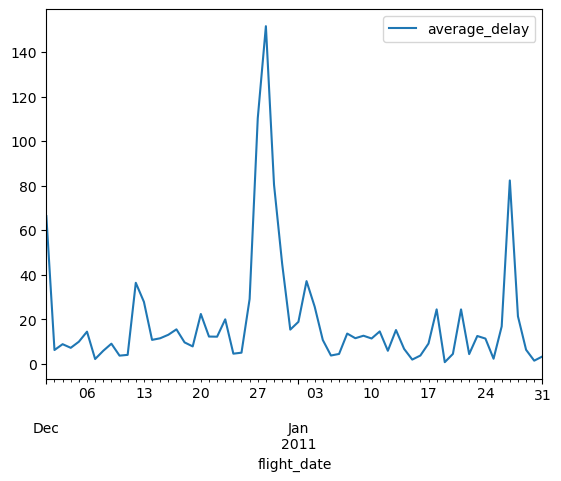

In [407]:
### check for delays of JFK Airport in New York 

delayed.loc[delayed['origin_name'] == 'John F Kennedy International Airport'][['flight_date', 'average_delay', 'origin_name']].set_index('flight_date').plot();

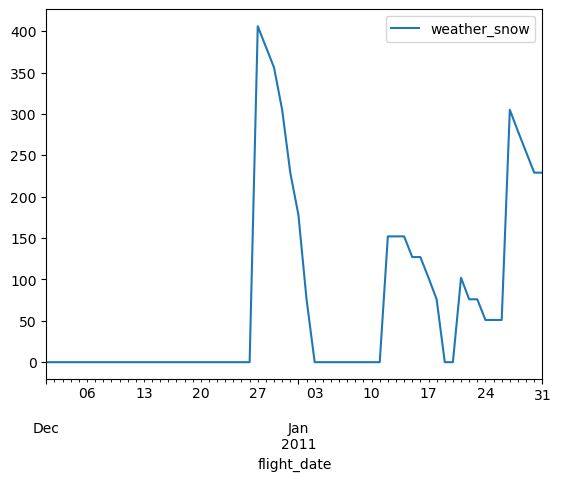

In [409]:
### check for snowfall of JFK Airport in New York 

delayed.loc[delayed['origin_name'] == 'John F Kennedy International Airport'][['flight_date', 'weather_snow', 'origin_name']].set_index('flight_date').plot();

In [443]:
### narrow down the timeframe to the peak of the storm

delayed_storm = delayed.loc[(delayed['flight_date'] > '2010-12-24') & (delayed['flight_date'] < '2010-12-31')]

# 11. Check for Correlation

In [426]:
### set a variable for correlation-table

correlation = round(delayed_storm.corr(method='pearson', numeric_only=True),1)

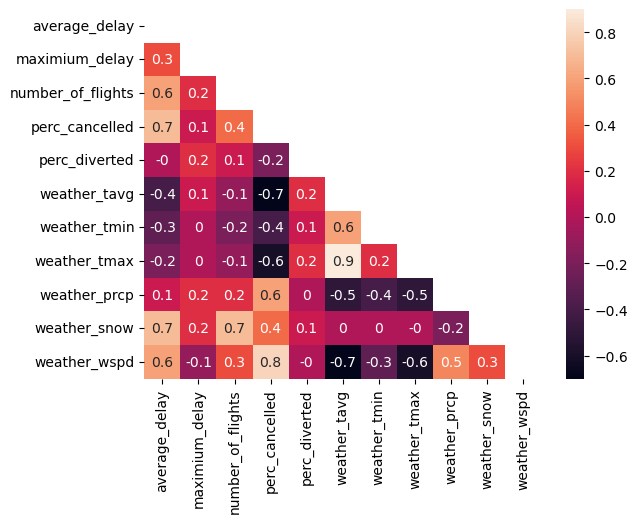

In [429]:
### create a heatmap 

mask = np.triu(np.ones_like(correlation))
dataplot = sns.heatmap(correlation, annot=True, mask=mask)

plt.show()

# 12. Narrow down to Snowfall, Rainfall and Windspeed + EDA on each Airport

In [668]:
### temperature has no influence on flights, also divertation has very small influence, so we will drop these columns 

df = delayed_storm.drop(['weather_tavg', 'weather_tmin', 'weather_tmax'], axis=1)
df.head(2)

,flight_date,origin_name,average_delay,maximium_delay,number_of_flights,perc_cancelled,perc_diverted,weather_prcp,weather_snow,weather_wspd
120,2010-12-25,General Edward Lawrence Logan International Ai...,7.133333,176.0,232,0.030172,0.000000,0.0,NaN,9.4
121,2010-12-25,John F Kennedy International Airport,5.077703,235.0,300,0.013333,0.003333,0.0,0.0,14.0


In [670]:
df_new = df.drop(['maximium_delay', 'number_of_flights'], axis=1)

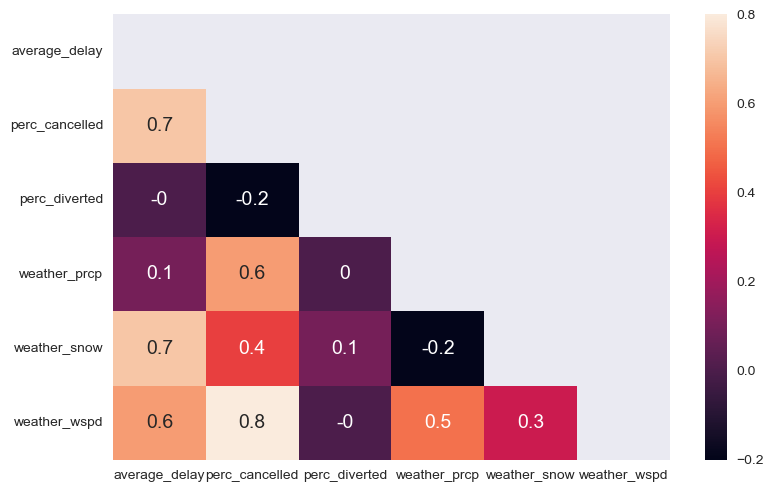

In [671]:
### create a new heatmap with only the important weather columns 

correlation_new = round(df_new.corr(method='pearson', numeric_only=True),1)
mask = np.triu(np.ones_like(correlation_new))
dataplot = sns.heatmap(correlation_new, annot=True, mask=mask)
plt.show()

* The average delay is heaviliy connected to Windspeed and Snowfall
* Cancellations are also connected Windspeed, Rainfall and Snowfall - in this particular order 
* Diversions seem to only be connected with Snowfall 

In [535]:
### list of all Airport Names 

airport_names = ['Philadelphia International Airport',
       'General Edward Lawrence Logan International Airport',
       'Washington Dulles International Airport', 'La Guardia Airport',
       'John F Kennedy International Airport']


# 13. Plotting

In [541]:
### Create Variables for each Airport

jfk = delayed_storm.loc[delayed_storm['origin_name'] == 'John F Kennedy International Airport'] #New York
phl = delayed_storm.loc[delayed_storm['origin_name'] == 'Philadelphia International Airport'] #Philadelphia
bos = delayed_storm.loc[delayed_storm['origin_name'] == 'General Edward Lawrence Logan International Airport'] #Boston
iad = delayed_storm.loc[delayed_storm['origin_name'] == 'Washington Dulles International Airport'] #Washington
lga = delayed_storm.loc[delayed_storm['origin_name'] == 'La Guardia Airport'] #New York

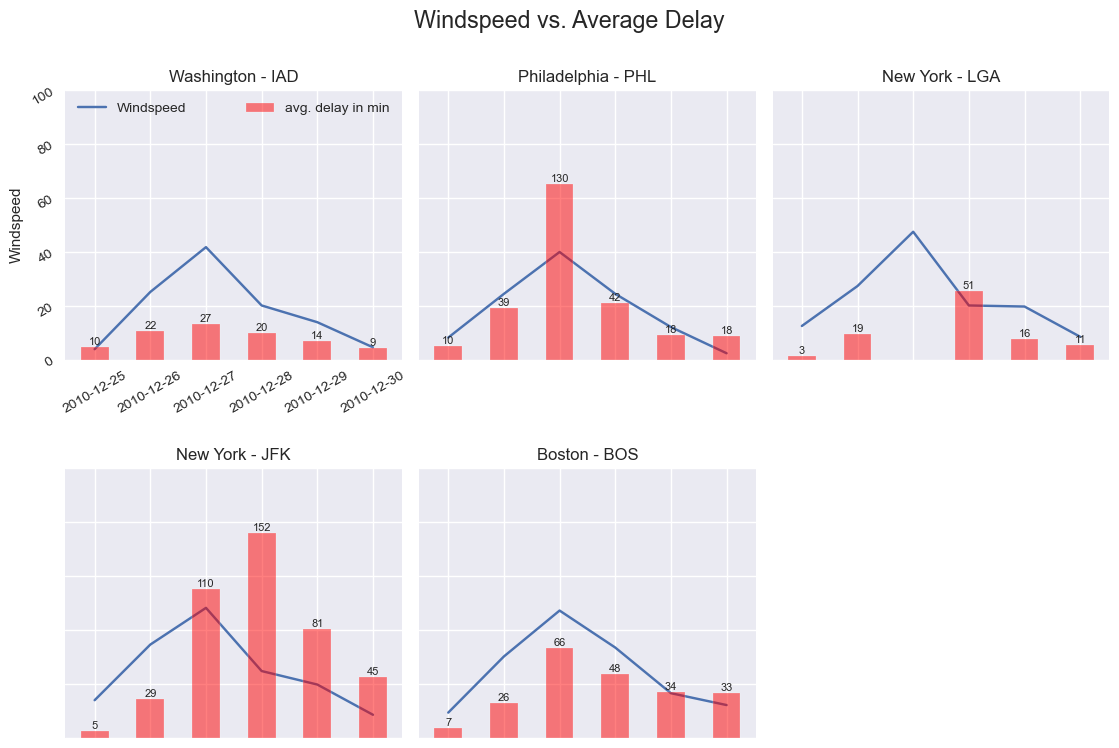

In [675]:
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(2,3)
fig.suptitle("Windspeed vs. Average Delay")

## iad Washington 
ax1 = fig.add_subplot(gs[0, 0])
ax1.title.set_text('Washington - IAD')
ax1.plot(iad.flight_date, iad.weather_wspd)
ax1.set_ylabel('Windspeed')
ax1.set_ylim(0,100)
ax1.legend(['Windspeed'], loc="upper left")
ax1.tick_params(labelrotation = 30)

ax2 = ax1.twinx()
bars = ax2.bar(iad.flight_date, iad.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.legend(['avg. delay in min'], loc="upper right")
#ax2.set_ylabel('avg. delay in min')
ax2.set(yticklabels=[])

## phl - philadelphia 
ax1 = fig.add_subplot(gs[0, 1])
ax1.title.set_text('Philadelphia - PHL')
ax1.plot(phl.flight_date, phl.weather_wspd)
ax1.set_ylim(0,100)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(phl.flight_date, phl.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.set(xticklabels=[], yticklabels=[])

## la guardia 
ax1 = fig.add_subplot(gs[0, 2])
ax1.title.set_text('New York - LGA')
ax1.plot(lga.flight_date, lga.weather_wspd)
ax1.set_ylim(0,100)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(lga.flight_date, lga.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.set(xticklabels=[], yticklabels=[])

## jfk
ax1 = fig.add_subplot(gs[1, 0])
ax1.title.set_text('New York - JFK')
ax1.plot(jfk.flight_date, jfk.weather_wspd)
ax1.set_ylim(0,100)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(jfk.flight_date, jfk.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.set(xticklabels=[], yticklabels=[])


## jfk
ax1 = fig.add_subplot(gs[1, 1])
ax1.title.set_text('Boston - BOS')
ax1.plot(bos.flight_date, bos.weather_wspd)
ax1.set_ylim(0,100)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(bos.flight_date, bos.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.set(xticklabels=[], yticklabels=[])

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.4)

fig.tight_layout
plt.show()

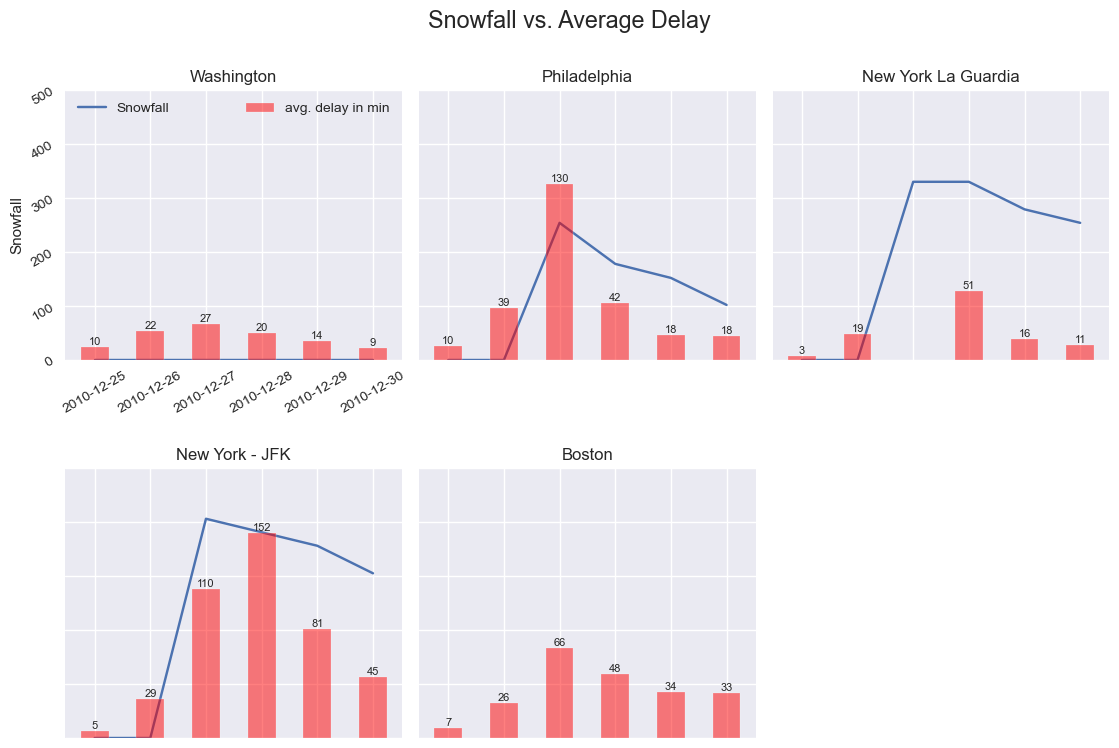

In [659]:
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(2,3)
fig.suptitle("Snowfall vs. Average Delay")

## iad Washington 
ax1 = fig.add_subplot(gs[0, 0])
ax1.title.set_text('Washington')
ax1.plot(iad.flight_date, iad.weather_snow)
ax1.set_ylabel('Snowfall')
ax1.set_ylim(0,500)
ax1.legend(['Snowfall'], loc="upper left")
ax1.tick_params(labelrotation = 30)

ax2 = ax1.twinx()
bars = ax2.bar(iad.flight_date, iad.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.legend(['avg. delay in min'], loc="upper right")
ax2.set(yticklabels=[])
#ax2.set_ylabel('avg. delay in min')

## phl - philadelphia 
ax1 = fig.add_subplot(gs[0, 1])
ax1.title.set_text('Philadelphia')
ax1.plot(phl.flight_date, phl.weather_snow)
ax1.set_ylim(0,500)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(phl.flight_date, phl.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.set(xticklabels=[], yticklabels=[])

## la guardia 
ax1 = fig.add_subplot(gs[0, 2])
ax1.title.set_text('New York La Guardia')
ax1.plot(lga.flight_date, lga.weather_snow)
ax1.set_ylim(0,500)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(lga.flight_date, lga.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.set(xticklabels=[], yticklabels=[])

## jfk
ax1 = fig.add_subplot(gs[1, 0])
ax1.title.set_text('New York - JFK')
ax1.plot(jfk.flight_date, jfk.weather_snow)
ax1.set_ylim(0,500)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(jfk.flight_date, jfk.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.set(xticklabels=[], yticklabels=[])


## jfk
ax1 = fig.add_subplot(gs[1, 1])
ax1.title.set_text('Boston')
ax1.plot(bos.flight_date, bos.weather_snow)
ax1.set_ylim(0,500)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(bos.flight_date, bos.average_delay, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.0f")
ax2.grid(False)
ax2.set_ylim(0,200)
ax2.set(xticklabels=[], yticklabels=[])

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.4)

fig.tight_layout
plt.show()

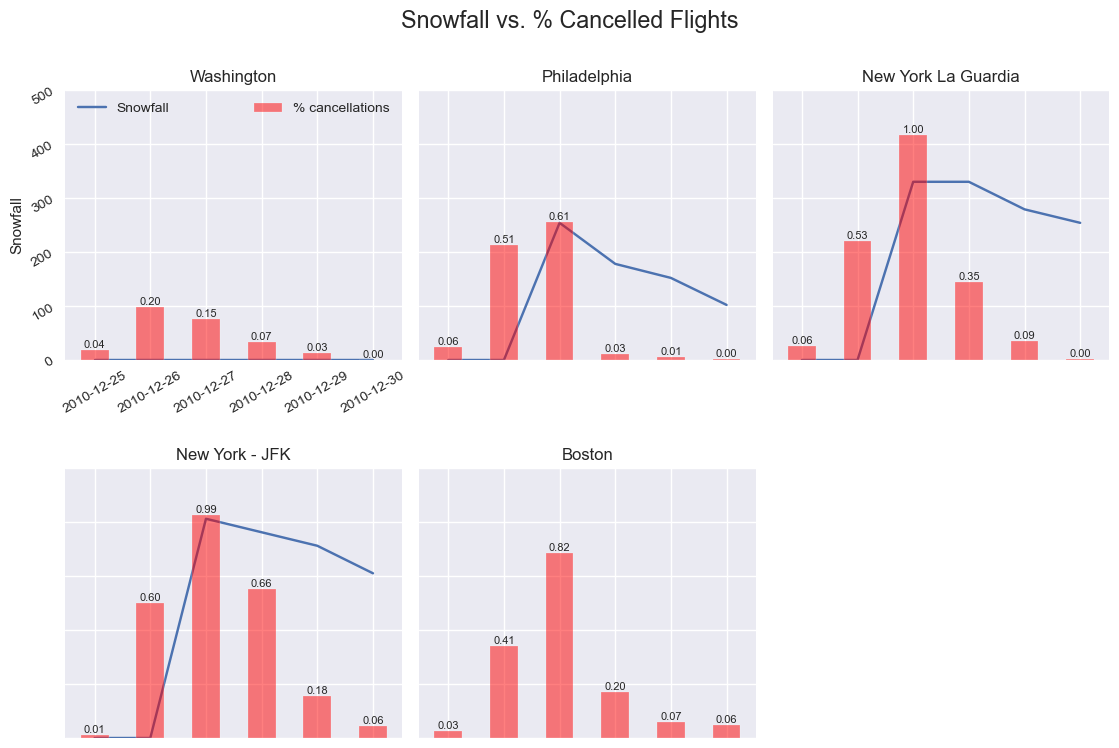

In [660]:
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(2,3)
fig.suptitle("Snowfall vs. % Cancelled Flights")

## iad Washington 
ax1 = fig.add_subplot(gs[0, 0])
ax1.title.set_text('Washington')
ax1.plot(iad.flight_date, iad.weather_snow)
ax1.set_ylabel('Snowfall')
ax1.set_ylim(0,500)
ax1.legend(['Snowfall'], loc="upper left")
ax1.tick_params(labelrotation = 30)

ax2 = ax1.twinx()
bars = ax2.bar(iad.flight_date, iad.perc_cancelled, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.2f")
ax2.grid(False)
ax2.set_ylim(0,1)
ax2.legend(['% cancellations'], loc="upper right")
ax2.set(yticklabels=[])
#ax2.set_ylabel('% cancellations')

## phl - philadelphia 
ax1 = fig.add_subplot(gs[0, 1])
ax1.title.set_text('Philadelphia')
ax1.plot(phl.flight_date, phl.weather_snow)
ax1.set_ylim(0,500)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)

ax2 = ax1.twinx()
bars = ax2.bar(phl.flight_date, phl.perc_cancelled, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.2f")
ax2.grid(False)
ax2.set_ylim(0,1.2)
ax2.set(xticklabels=[], yticklabels=[])

## la guardia 
ax1 = fig.add_subplot(gs[0, 2])
ax1.title.set_text('New York La Guardia')
ax1.plot(lga.flight_date, lga.weather_snow)
ax1.set_ylim(0,500)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars= ax2.bar(lga.flight_date, lga.perc_cancelled, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.2f")
ax2.grid(False)
ax2.set_ylim(0,1.2)
ax2.set(xticklabels=[], yticklabels=[])

## jfk
ax1 = fig.add_subplot(gs[1, 0])
ax1.title.set_text('New York - JFK')
ax1.plot(jfk.flight_date, jfk.weather_snow)
ax1.set_ylim(0,500)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(jfk.flight_date, jfk.perc_cancelled, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.2f")
ax2.grid(False)
ax2.set_ylim(0,1.2)
ax2.set(xticklabels=[], yticklabels=[])


## jfk
ax1 = fig.add_subplot(gs[1, 1])
ax1.title.set_text('Boston')
ax1.plot(bos.flight_date, bos.weather_snow)
ax1.set_ylim(0,500)
ax1.set(xticklabels=[], yticklabels=[])
ax1.tick_params(labelrotation = 30)
ax2 = ax1.twinx()
bars = ax2.bar(bos.flight_date, bos.perc_cancelled, width=0.5, alpha=0.5, color='red')
ax2.bar_label(bars, fontsize=8, label_type='edge', fmt="%.2f")

ax2.grid(False)
ax2.set_ylim(0,1.2)
ax2.set(xticklabels=[], yticklabels=[])

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.4)

fig.tight_layout
plt.show()